In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy as sp
from scipy import interpolate, signal
from scipy.stats import moyal
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import random
import pandas as pd
import warnings
from cycler import cycler
from siggen_pulses import *
from oneshot import *
from radiation import *
import matplotlib
import csv
from pprint import pprint

q = 1.602e-19 # C/electron

%matplotlib inline

In [3]:
# print(plt.rcParams)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rcParams.update(params)

In [4]:
# Plotting settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana',
                                   'Computer Modern Sans Serif',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Lucida Grande',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',
                                   'Helvetica',
                                   'Avant Garde',
                                   'sans-serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = (cycler(color=['r', 'g', 'b', 'y']) + 
                                   cycler(linestyle=['-', '--', ':', '-.']))
# font = {'family': 'sans-serif',
#         'fantasy': 'xkcd',
# #         'sans-serif': 'arial',
#        'weight':'normal',
#        'size':20}
# rc('font', **font)

# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

<h1>ToF Data</h1>
<h2>Histogram</h2>

In [5]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_names = ['MQ{0}'.format(x) for x in (1,2,4,14,16,18,20,28,29,30,38,39,40)]
# mq_names = ['MQ{0}'.format(x) for x in (29,30)]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [6]:
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
mq_distrib_dict = {mq:data[mq] for mq in mq_names}

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


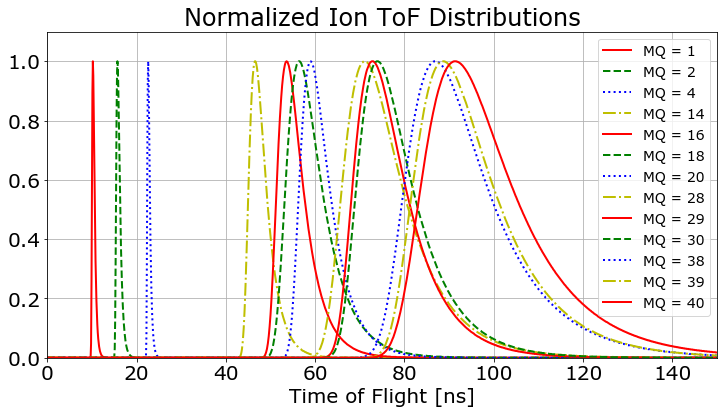

In [7]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
# xlim = (60, 140)
figsize = (12, 6)

# Plotting
fig, ax = plt.subplots(figsize=figsize)
for i, mq in enumerate(mq_names):
    # Histograms
    mq_value = mq.replace('MQ', '')
    mq_label = f'MQ = {mq_value}'
    mq_distrib = mq_distrib_dict[mq]
    ax.plot(times, mq_distrib, label=mq_label, linewidth=2)
    
    # Annotate peak of histogram with MQ
#     mq_annot = mq
#     idx_peak = np.argmax(mq_distrib)
#     y_peak = max(mq_distrib)
#     x_peak = times[idx_peak]
#     loc_annot = (x_peak, y_peak*1.05)
#     ax.annotate(s=mq_annot, xy=loc_annot)
    
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
# ax.set_title('Normalized Ion ToF Distributions\nProton Particle, 16keV, 2cm')
ax.set_title('Normalized Ion ToF Distributions')
ax.grid(True)
ax.set_ylim(ylim)
ax.set_xlim(xlim);

<h2>ToF vs. MQ</h2>

In [8]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_vec = (1,2,4,14,16,18,20,28,29,30,38,39,40)
mq_loss_vec = (1, 4, 14, 16, 20, 40)
E_loss_vec = (5.039e2, 5.637e2, 1.076e3, 1.016e3, 7.605e2, 1.150e3) # eV/(ug/cm^2)
foil_thickness = 4.5 # ug/cm^2
voltage = 16e3 # 16e3
length = 2e-2
m_proton = 1.67e-27
mq_norm = m_proton/q

In [9]:
mq_names = [f'MQ{x}' for x in mq_vec]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [10]:
# Getting the mode of the distributions (there's a tail)
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
t_mode_vec = []

for mq in mq_vec:
    data_hist = data[f'MQ{mq}']
    
    idx_mode = np.argmax(data_hist)
    t_mode = times[idx_mode]
    t_mode_vec.append(t_mode)

In [11]:
# Fitting to sqrt plot
def fit_func(mq, K):
    return np.sqrt(mq) * K

popt, pcov = curve_fit(fit_func, mq_vec, t_mode_vec)

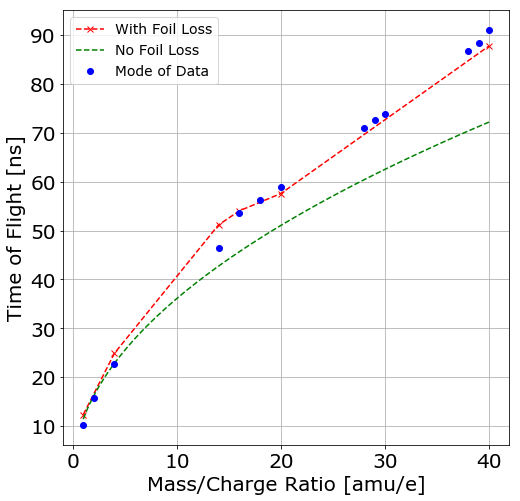

In [12]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
figsize = (8, 8)

# Plotting data vs. ideal
fig, ax = plt.subplots(figsize=figsize)
mq_fit_vec = np.linspace(min(mq_vec), max(mq_vec), 100)
t_ideal_vec = [np.sqrt(1/(2*voltage) * mq * mq_norm)*length*1e9 for mq in mq_fit_vec]
t_loss_vec = [np.sqrt(1/(2*(voltage-E_loss_vec[i]*foil_thickness)) * mq * mq_norm)*length*1e9 for i,mq in enumerate(mq_loss_vec)]

ax.plot(mq_loss_vec, t_loss_vec, 'x--', label='With Foil Loss')
ax.plot(mq_fit_vec, t_ideal_vec, label='No Foil Loss')
ax.plot(mq_vec, t_mode_vec, 'o', label='Mode of Data')
# ax.plot(mq_fit_vec, fit_func(mq_fit_vec, *popt), label='Theory With Foil Loss')

ax.set_ylabel('Time of Flight [ns]')
ax.set_xlabel('Mass/Charge Ratio [amu/e]')
ax.grid(True)
ax.legend()

In [13]:
print(popt)
print(t_ideal_vec[0])
print(t_mode_vec[0])

[13.62851836]
11.415159554969796
10.2


In [21]:
# pprint(t_mode_vec)
pprint(mq_vec)
t_mode_diffs = np.array(t_mode_vec[1:])-np.array(t_mode_vec[:-1])
pprint(t_mode_diffs)
# pprint([t_mode_vec[i+1]-t_mode_vec[i] for i,_ in enumerate(t_mode_vec[:-1])])

(1, 2, 4, 14, 16, 18, 20, 28, 29, 30, 38, 39, 40)
array([ 5.5,  6.9, 23.9,  7.1,  2.7,  2.6, 12.1,  1.7,  1.1, 12.9,  1.7,
        2.7])


In [46]:
pprint(max([i for i,x in enumerate(mq_distrib_dict['MQ29']) if x > 0]))
print(mq_distrib_dict['MQ29'][617])
print(mq_distrib_dict['MQ29'][1339])
print(times[617])
print(times[1339])

1339
0.001
0.001
61.7
133.9


<h2>ToF with Moyal Distribution Loss at Carbon Foil</h2>

In [ ]:
# Moyal distribution
fig, ax = plt.subplots()
mu = 0
c = 1
L = 1
m = 1
qV = 1

Eloss_vec = np.linspace(moyal.ppf(0.01),
                moyal.ppf(0.99), 100)
moyal_vec = moyal.pdf(Eloss_vec, mu, c)
t_vec = L*np.sqrt(m/(2*(qV - Eloss_vec)))
ax.plot(Eloss_vec, t_vec)

<h1>Radiation</h1>
<h2>Stopping Power</h2>

In [ ]:
file_names = ['../data/srim/IONIZ_H3MeV_Si_v2.csv',
              '../data/srim/IONIZ_He10MeV_Si.csv',]
# #               '../data/srim/IONIZ_Si10MeV_Si.csv',
#               '../data/srim/IONIZ_H1GeV_Si.csv',
#               '../data/srim/IONIZ_H10GeV_Si.csv']
labels = ['3MeV proton',
          '10MeV alpha',]
#           '10MeV Si',
#           '1GeV proton',
#           '10GeV proton']
figsize = (12, 6)
x_qdepth = 20 # Charge collection depth in um
E_ion = 3.6 # Energy in eV required to generate an electron hole pair
v_SET_max = 1.8/2**9

# Plotting
fig, ax = plt.subplots(figsize=figsize)

q_SET_vec = []

# Parse data
for idx, fname in enumerate(file_names):
    data = pd.read_csv(fname)
    depth = list(data['Target Depth']) # Angstroms
    i_by_i = list(data['Ionization by Ions']) # eV/(Angstrom-Ion)
    i_by_r = list(data['Ionization by Recoils']) # eV/(Angstrom-Ion)
    
    depth = [(d * 1e-4) for d in depth] # Microns
    i_by_i = [x*1e4/1e3 for x in i_by_i] # keV/(um-ion)
    
    depth_nozero = []
    i_by_i_nozero = []
    
    for i, ions in enumerate(i_by_i):
        if ions > 0:
            depth_nozero.append(depth[i])
            i_by_i_nozero.append(ions)
            
    print(f"{labels[idx]} - {i_by_i_nozero[0]} keV/micron upon entry")
        
    ax.semilogy(depth_nozero, i_by_i_nozero, label=labels[idx])
#     print(depth_nozero)
    
    # Estimate number of generated ehp in the charge collecting region
    spl = UnivariateSpline(depth_nozero, i_by_i_nozero)
    
    E_qdepth = spl.integral(0, x_qdepth)
    ehp_qdepth = E_qdepth / E_ion
    q_qdepth = ehp_qdepth * q
    q_SET_vec.append(q_qdepth)
    print(f'\tQ_SET = {q_qdepth} C')

ax.set_ylabel('Stopping Power [keV/micron]')
ax.set_xlabel('Depth [microns]')
ax.legend()
ax.grid(True)

In [ ]:
for i, particle in enumerate(labels):
    q_SET = q_SET_vec[i]
    c_min = q_SET/v_SET_max
    print(f'{particle}:\t{c_min} F')

In [ ]:
E_particle = 10e6 # eV
num_ehp = E_particle/3.6
Q_SET = num_ehp * q

<h2>Stopping Power and the Like vs. Energy</h2>

In [3]:
fname = '../data/srim/TAB_H_Si.csv'

figsize = (12, 6)
x_qdepth = 1 # Charge collection depth in um
E_ion = 3.6 # Energy in eV required to generate an electron hole pair
v_SET_max = 1.8/2**9

In [4]:
# Parse data
norm = 2.3211e2 # MeV/(mg/cm^3) -> keV/um in Si
data = pd.read_csv(fname)

energy_vec = list(data['Ion Energy (eV)'])

let_vec = list(data['dE/dx Elec.']) # MeV/(mg/cm^2)
let_vec_norm = [x*norm for x in let_vec] # keV/um
range_vec = list(data['Projected Range (um)']) # um
lost_energy_vec = [(let*x_qdepth if x_qdepth<range_vec[i] else energy_vec[i]) for i,let in enumerate(let_vec_norm)] # keV
ehp_vec = [E*1e3/E_ion for E in lost_energy_vec]
charge_vec = [ehp * q for ehp in ehp_vec]

Text(0,0.5,'Collected Charge [C]')

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


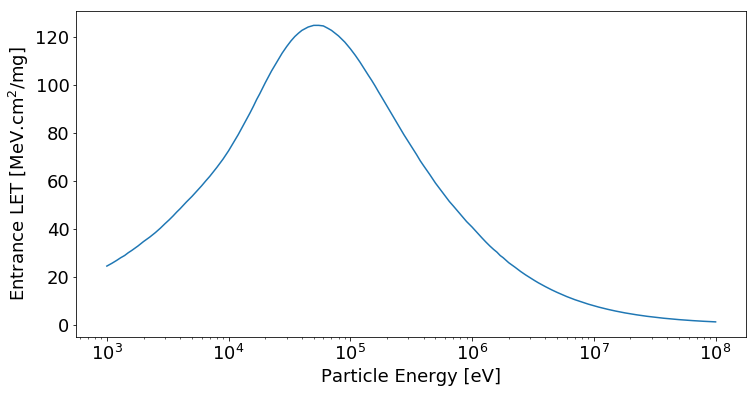

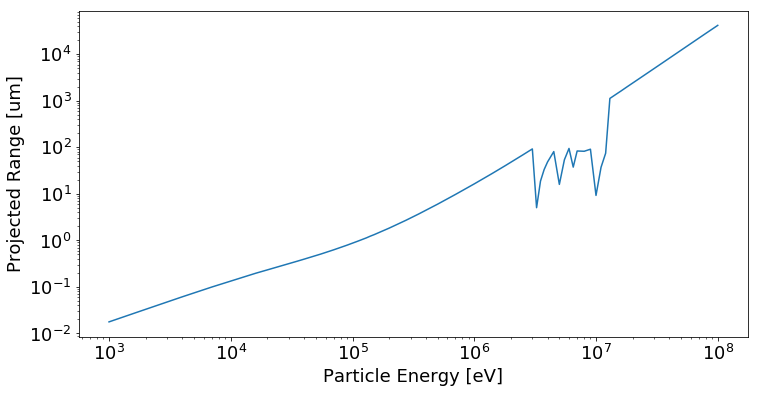

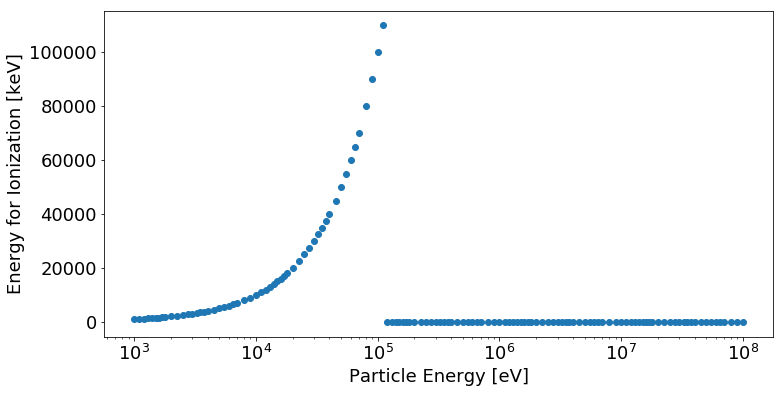

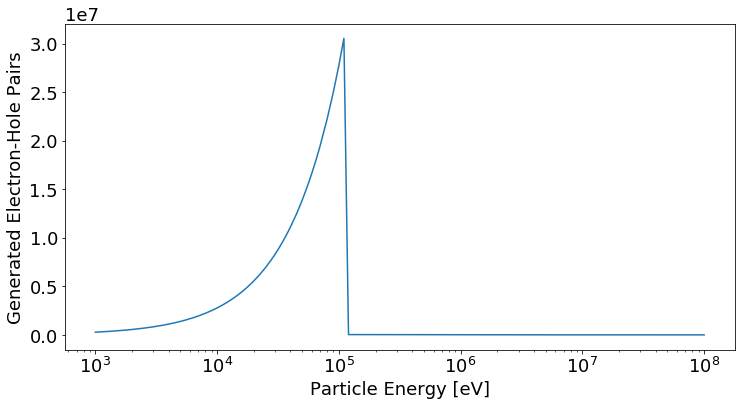

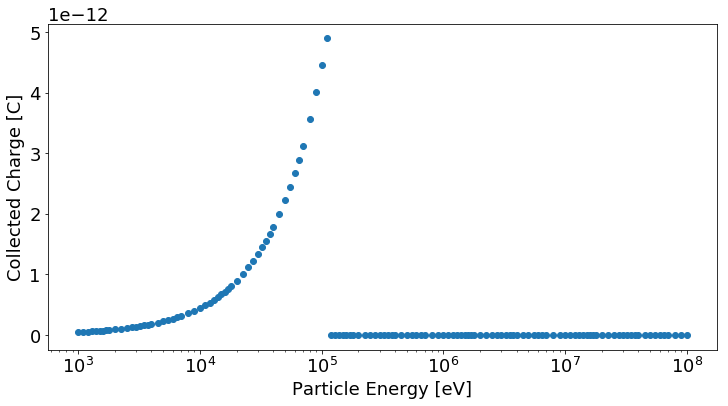

In [5]:
# Plotting
fig0, ax0 = plt.subplots(figsize=figsize)
fig1, ax1 = plt.subplots(figsize=figsize)
fig2, ax2 = plt.subplots(figsize=figsize)
fig3, ax3 = plt.subplots(figsize=figsize)
fig4, ax4 = plt.subplots(figsize=figsize)

ax0.semilogx(energy_vec, let_vec_norm)
ax1.loglog(energy_vec, range_vec)
ax2.semilogx(energy_vec, lost_energy_vec, 'o')
ax3.semilogx(energy_vec, ehp_vec)
ax4.semilogx(energy_vec, charge_vec, 'o')

ax0.set_xlabel('Particle Energy [eV]')
ax0.set_ylabel('Entrance LET [MeV.cm$^2$/mg]')
ax1.set_xlabel('Particle Energy [eV]')
ax1.set_ylabel('Projected Range [um]')
ax2.set_xlabel('Particle Energy [eV]')
ax2.set_ylabel('Energy for Ionization [keV]')
ax3.set_xlabel('Particle Energy [eV]')
ax3.set_ylabel('Generated Electron-Hole Pairs')
ax4.set_xlabel('Particle Energy [eV]')
ax4.set_ylabel('Collected Charge [C]')

In [6]:
### LBL Data
fname = '../data/srim/TAB_LBL.csv'

figsize = (12, 6)
x_qdepth = 1 # Charge collection depth in um
E_ion = 3.6 # Energy in eV required to generate an electron hole pair
v_SET_max = 1.8/2**9

In [7]:
q_SET_vec = []

# Parse data
norm = 2.3211e2 # MeV/(mg/cm^2) -> keV/um in Si
data = pd.read_csv(fname)

col_ion = list(data['Ion'])
col_cocktail = list(data['Cocktail (MeV)'])
col_energy = list(data['Energy (MeV)'])
col_LET_entr_vac = list(data['LET (Entrance)'])
col_range_vac = list(data['Range (Bragg, Vacuum)'])

ions_info = {ion : dict() for ion in set(col_ion) if '*' not in ion}

for i, ion in enumerate(col_ion):
    if '*' in ion:
        continue
    ions_dict = ions_info[ion]
    cocktail = col_cocktail[i]
    E_original = col_energy[i] * 1e6 # eV
    let_entr_vac = col_LET_entr_vac[i] # MeV/(mg/cm^2)
    let_entr_vac_norm = norm*let_entr_vac*1e3 # eV/um
    range_vac = col_range_vac[i] if type(col_range_vac[i])==float else 0
    
    # True if the particle is expected to stop within the depth
    stopped = range_vac < x_qdepth
    
    # Calculating the energy lost
    E_lost = E_original if stopped else let_entr_vac_norm * x_qdepth # eV
    ehp = E_lost/E_ion
    charge = ehp * q # Coulombs
    
    ions_dict[cocktail] = dict(E_lost=E_lost,
                               ehp=ehp,
                               charge=charge,
                               E_original=E_original)

# let_vec = list(data['dE/dx Elec.']) # MeV/(mg/cm^2)
# let_vec_norm = [x*norm for x in let_vec] # keV/um
# range_vec = list(data['Projected Range (um)']) # um
# lost_energy_vec = [(let*x_qdepth if x_qdepth<range_vec[i] else energy_vec[i]) for i,let in enumerate(let_vec_norm)] # keV
# ehp_vec = [E*1e3/E_ion for E in lost_energy_vec]
# charge_vec = [ehp * q for ehp in ehp_vec]

In [8]:
ion_parsed_info = dict()
for ion, ion_dict in ions_info.items():
    energy_vec = []
    charge_vec = []
    for cocktail in ion_dict.keys():
        energy_vec.append(ion_dict[cocktail]['E_original'])
        charge_vec.append(ion_dict[cocktail]['charge'])
    ion_parsed_info[ion] = dict(energy_vec=energy_vec,
                                charge_vec=charge_vec)

Text(0.5,1,'Single Event Charge\nSi Substrate, 1 Micron Sensitive Depth')

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


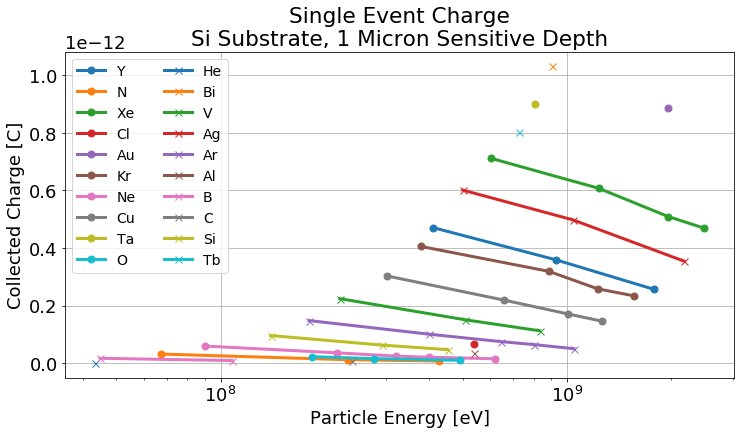

In [12]:
fig, ax = plt.subplots(figsize=figsize)
prop_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_prop_cycle(color=list(prop_colors)*2,
                  marker=['o']*10 + ['x']*10)

for ion, vecs in ion_parsed_info.items():
    charge_vec = vecs['charge_vec']
    energy_vec = vecs['energy_vec']
    ax.semilogx(energy_vec, charge_vec, linewidth=3.0, markersize=7, label=ion)
ax.set_xlabel('Particle Energy [eV]')
ax.set_ylabel('Collected Charge [C]')
ax.legend(ncol=2)
ax.grid(True)
ax.set_title('Single Event Charge\nSi Substrate, 1 Micron Sensitive Depth')

In [ ]:
ion_parsed_info['Ta']

<h2>Not-Quite-Particle</h2>

In [ ]:
E_i = 59.5e3
theta_vec = np.linspace(-np.pi, np.pi, 100)
E_ion = 3.6

figsize = (6, 3)

In [ ]:
# Calculate Compton scattering for different angles
lambda_i = h_eV * c / E_i
Q_vec = []
for theta in theta_vec:
    lambda_f, num_ehp = scatter_compton(lambda_i, theta, E_ion)
    Q_vec.append(num_ehp*q)

# Plotting
fig, ax = plt.subplots(figsize=figsize)

ax.plot(theta_vec, Q_vec)
ax.set_ylabel('Charge [C]')
ax.set_xlabel('Scattering Angle [rad]')
ax.set_title('Induced Charge in a Single \nCompton Scattering Event')
ax.grid(True)

<h3>X-Ray</h3>

In [ ]:
lambda_min = 1e-11
lambda_max = 1e-8

In [ ]:
E_max = get_E(lambda_min)
E_min = get_E(lambda_max)

print(E_min, E_max)

<h3>Gamma</h3>

In [ ]:
lambda_gamma = 1e-12
E_gamma = get_E(lambda_gamma)
E_gamma

<h1>One-Shot Results Statistics</h1>

<h2>Code Sweep</h2>

In [140]:
file_names = ['../data/1p8/data_1nsPulse_randPeriod_R10kC1p_yesReset.csv', 
              '../data/1p8/data_1nsPulse_randPeriod_R20kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R30kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R40kC1p_yesReset.csv']
#               '../data/1p8/data_1nsPulse_randPeriod_00_noReset.csv']
# file_names = ['../data/data_1nsPulse_randPeriod_R20kC1p_noReset.csv',
#               '../data/data_1nsPulse_randPeriod_R20kC1p_yesReset.csv']
data_dicts = [parse_pulse(file_name) for file_name in file_names]

pulse_widths_specs = [dict(data_dict = data_dict,
                          sig_threshold = 0.9,
                          posedge = True) for data_dict in data_dicts]
pulse_widths_lists = [get_pulse_widths(**pulse_widths_spec) for pulse_widths_spec in pulse_widths_specs]

No handles with labels found to put in legend.
C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


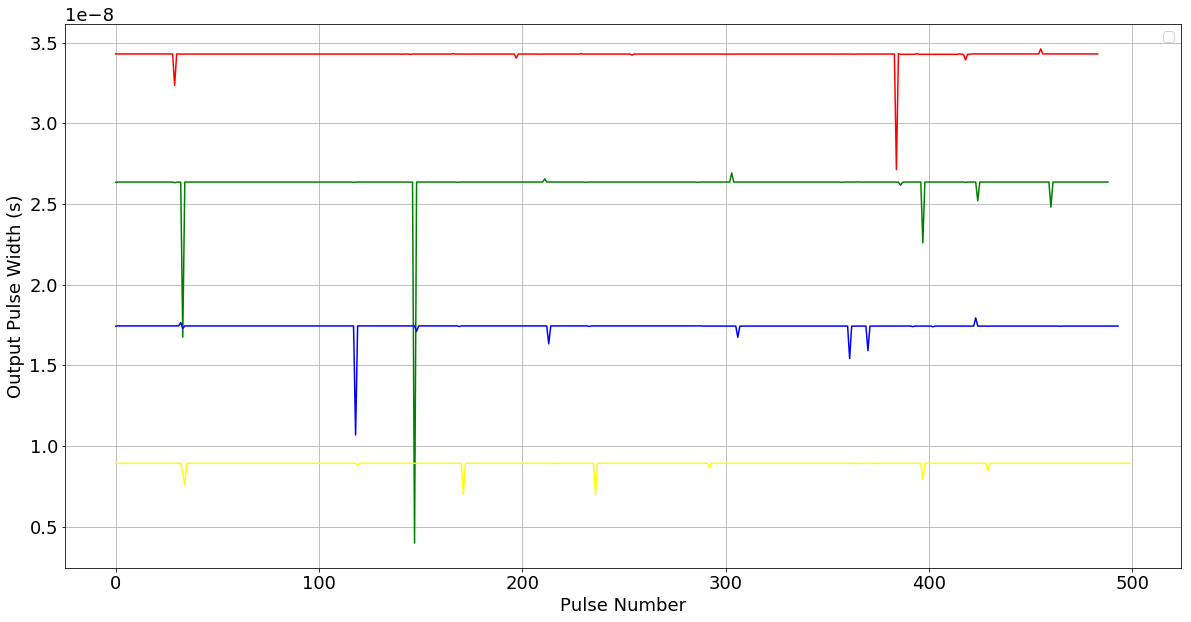

In [141]:
# Plotting
figsize = (20, 10)

fig, ax = plt.subplots(figsize=figsize)
color_cycle = ['red', 'green', 'blue', 'yellow', 'black']
for i,pulse_width_list in enumerate(pulse_widths_lists):
    ax.plot(pulse_width_list, color_cycle[i])
# ax.plot(pulse_widths_lists[0], 'red', label='3')
# ax.plot(pulse_widths_lists[1], 'green', label='2')
# ax.plot(pulse_widths_lists[2], 'blue', label='1')
# ax.plot(pulse_widths_lists[3], 'yellow', label='0')
# ax.plot(pulse_widths_lists[4], 'black', label='no')

ax.set_xlabel('Pulse Number')
ax.set_ylabel('Output Pulse Width (s)')
ax.legend()
# ax.set_title(f'Mean = {np.average(pulse_width_list)*1e9} ns\nStdDev = {np.std(pulse_width_list)*1e9} ns')
ax.grid(True)

Text(0.5,1,'One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


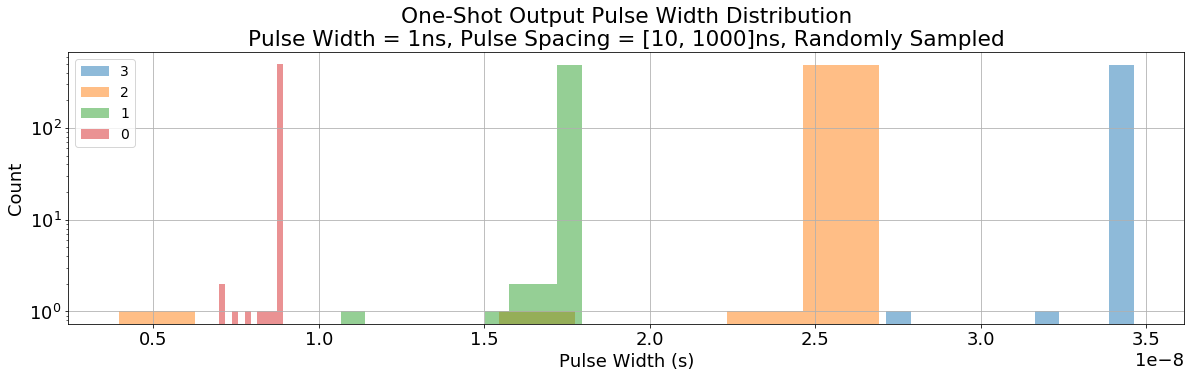

In [147]:
# Histogram
figsize = (20, 5)
num_bins = 100

fig, ax = plt.subplots(figsize=figsize)
for i,pulse_widths in enumerate(pulse_widths_lists):
    ax.hist(pulse_widths, label=f'{(3-i)}', log=True, alpha=0.5)
# ax.hist(pulse_widths_lists, bins=num_bins, label=['3', '2', '1', '0'], log=True, alpha=0.5)
# ax.hist(pulse_widths_lists[0], bins=num_bins, label='No Reset', alpha=0.7)
# ax.hist(pulse_widths_lists[1], bins=num_bins, label='Yes Reset', alpha=0.7)
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)
ax.set_title('One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')
# ax.set_title('Pulse Width = 1ns\nPulse Spacing = [1, 100]ns, Randomly Sampled')

Percentage of pulses >20% away from the median:
    Without Reset:	29.38775510204082
    With Reset:		4.417670682730924
Standard Deviations:
    Without Reset:	3.5351774445772456e-09
    With Reset:		1.906033054507892e-09


C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


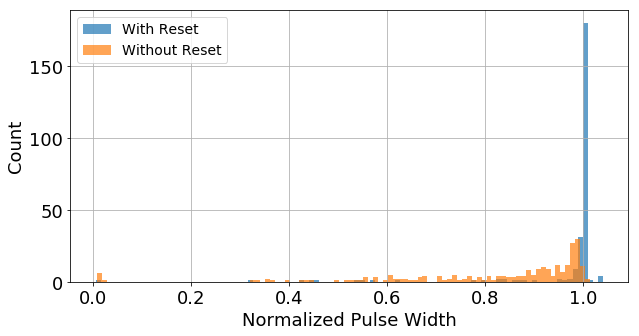

In [139]:
figsize = (10, 5)
num_bins = 100

test_yesReset = pulse_widths_lists[1]
test_noReset = pulse_widths_lists[0]

yesReset_med = np.median(test_yesReset)
noReset_med = np.median(test_noReset)

test_yesReset_norm = [x/yesReset_med for x in test_yesReset]
test_noReset_norm = [x/yesReset_med for x in test_noReset]

fig, ax = plt.subplots(figsize=figsize)
ax.hist(test_yesReset_norm, bins=num_bins, label='With Reset', alpha=0.7)
ax.hist(test_noReset_norm, bins=num_bins, label='Without Reset', alpha=0.7)
ax.grid(True)
ax.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Normalized Pulse Width')

pct_error = 20
pct_noReset = [x for x in test_noReset_norm if abs(x-1) > pct_error/100]
frac_pct_noReset = len(pct_noReset)/len(test_noReset)

pct_yesReset = [x for x in test_yesReset_norm if abs(x-1) > pct_error/100]
frac_pct_yesReset = len(pct_yesReset)/len(test_yesReset)

print(f'''Percentage of pulses >{pct_error}% away from the median:
    Without Reset:\t{frac_pct_noReset*100}
    With Reset:\t\t{frac_pct_yesReset*100}''')

print(f'''Standard Deviations:
    Without Reset:\t{np.std(test_noReset)}
    With Reset:\t\t{np.std(test_yesReset)}''')

<h2>Monte Carlo</h2>

In [ ]:
file_names = ['../data/1p8/simData_0.csv', 
              '../data/1p8/simData_1.csv',
              '../data/1p8/simData_2.csv',
              '../data/1p8/simData_3.csv']
pulse_widths_lists = [[]] * 4

for code, fname in enumerate(file_names):    
    with open(fname) as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            row_flt = [float(x) for x in row]
            pulse_widths_lists[code] = pulse_widths_lists[code] + row_flt

In [ ]:
# Histogram
figsize = (20, 5)
num_bins = 10000

fig, ax = plt.subplots(figsize=figsize)
# ax.hist(pulse_width_list, bins=100)
ax.hist(pulse_widths_lists, bins=num_bins, label=['0', '1', '2', '3'])
# ax.hist(pulse_widths_lists[0], color='red', bins=num_bins, alpha=1, label='3')
# ax.hist(pulse_widths_lists[1], color='green', bins=num_bins, alpha=1, label='2')
# ax.hist(pulse_widths_lists[2], color='blue', bins=num_bins, alpha=1, label='1')
# ax.hist(pulse_widths_lists[3], color='black', bins=num_bins, alpha=1, label='0')
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)
ax.set_title('One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')
# ax.set_title('Pulse Width = 1ns\nPulse Spacing = [1, 100]ns, Randomly Sampled')

<h1>Folded Cascode</h1>
<h2>Checking Bode Plot of Folded Cascode vs. Sim</h2>

In [ ]:
num = np.array([-3.53895594e-004, -4.70738415e+007,  1.50356235e+019,
        2.47926605e+030,  1.59517475e+041,  5.75769776e+051,
        1.30387570e+062,  1.93756258e+072,  1.91312015e+082,
        1.24175010e+092,  5.11668364e+101,  1.24882971e+111,
        1.58562663e+120,  8.12989223e+128,  5.24596567e+136])
den = np.array([1.00000000e+000, 1.48311234e+011, 9.64486755e+021, 3.62458359e+032,
       8.73205029e+042, 1.41372736e+053, 1.56752525e+063, 1.18986463e+073,
       6.07158733e+082, 2.00068022e+092, 3.95710939e+101, 4.14370181e+110,
       1.90680507e+119, 2.22072378e+127, 7.55724493e+134])

s1 = signal.lti(num, den)
w, mag, phase = s1.bode()

In [ ]:
plt.figure()
plt.semilogx(w, mag, 'r')
plt.semilogx(w, phase, 'b')
plt.grid(True)

In [ ]:
print(mag[69])
print(phase[69])

<h1>Delay</h1>
<h2>Sallen Key Calculations</h2>

In [ ]:
tdelay = 2e-9
C1 = 50e-15
C2 = 30e-15

#############

omega_0 = 1/tdelay
k1 = 1/(3 * omega_0**2 * C1 * C2)
k2 = 3*omega_0 * C1 * k1

# x(k2 - x) = k1 -> x^2 - k2x + k1 = 0
sqrt_term = k2**2 - 4*k1
print(sqrt_term)

R1_plus = (k2 + np.sqrt(sqrt_term))/2
R1_minus = (k2 - np.sqrt(sqrt_term))/2

R2_plus = k2 - R1_plus
R2_minus = k2 - R1_minus

In [ ]:
print(R1_plus, R1_minus)
print(R2_plus, R2_minus)

In [ ]:
R1_plus+R2_plus

In [ ]:
k2

<h1>Peak Detector + Attenuator</h1>
<h2>Error Plot</h2>

In [ ]:
file_name = '../data/peakDetector_attenuator_error.csv'
data = pd.read_csv(file_name)
code_vec = list(data['code'])
data_n85 = list(data['-85'])
data_27 = list(data['27'])
data_125 = list(data['125'])

figsize = (20, 10)
fig, ax = plt.subplots(figsize=figsize)

ax.semilogy(code_vec, data_n85, 'r-o', label='-85')
ax.semilogy(code_vec, data_27, 'g-*', label='27')
ax.semilogy(code_vec, data_125, 'b--', label='125')
ax.legend()
ax.grid(True)
ax.set_title('Peak Detector + Attenuator Output Error\nVstep=229.86mV')
ax.set_xlabel('Digital Code')
ax.set_ylabel('Error (mV)')

<h2>Analog Majority</h2>

In [ ]:
def majority_test(x, y, z):
    return max(min(x, y), min(x, z), min(y, z))
#     return min(max(x, y), max(x, z), max(y, z))

In [ ]:
val_majority = 0.5
val_high = 1
val_low = 0
for x in [val_high, val_low]:
    print(majority_test(x, val_majority, val_majority))
    
for y in [val_high, val_low]:
    print(majority_test(val_majority, y, val_majority))
    
for z in [val_high, val_low]:
    print(majority_test(val_majority, val_majority, z))

<h1>Cadence Miscellanea</h1>
<h2>Pin Generation for Cadence Layout</h2>

In [1]:
' '.join([f'out<{404+6*x}>' for x in range(18)])

'out<404> out<410> out<416> out<422> out<428> out<434> out<440> out<446> out<452> out<458> out<464> out<470> out<476> out<482> out<488> out<494> out<500> out<506>'

<h1>DAC Mapping</h2>

In [ ]:
dac_dict = {x:x+144 for x in range(32)}
print('mux : resistor')
pprint(dac_dict)

In [ ]:
(.62-.28)/2

<h2>Resistor Flavors</h2>

In [ ]:
flavors = ['nlpoly',
           'nlplus',
           'nlpoly',
           'nplus',
           'nwell',
           'nwod',
           'phpoly',
           'phripoly',
           'plplus',
           'plpoly',
           'pplus']

In [ ]:
for r in flavors:
    print(f'((ymax(dc_res{r}) - ymin(dc_res{r})) / value(dc_res{r} 27))')

<h1>Walk Sim</h1>

In [15]:
x_walk = np.arange(.5, .95, .05)
y_walk = np.array([340e-12, 320e-12, 300e-12, 160e-12, 70e-12, 40e-12, 20e-12, 160e-12, 330e-12])

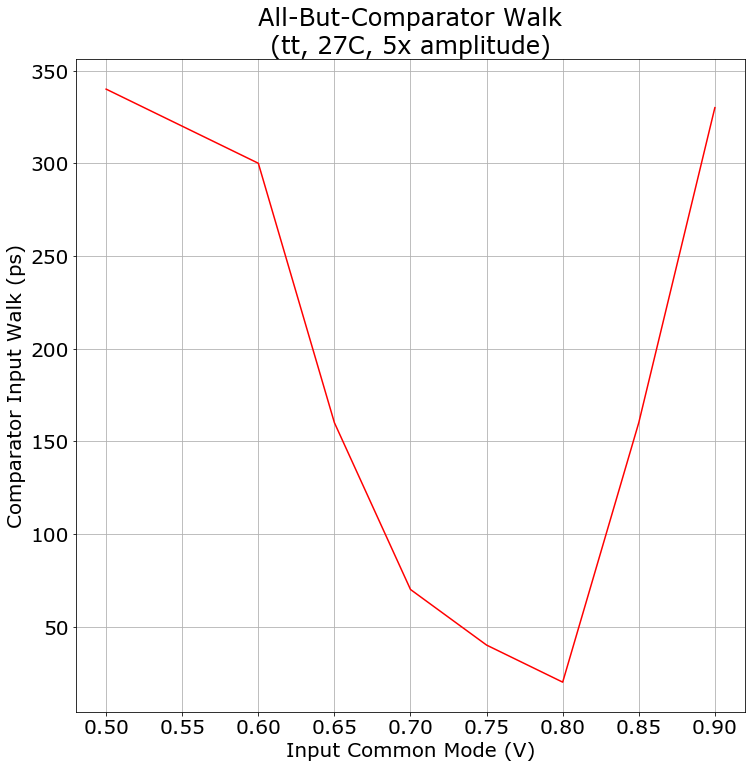

In [30]:
figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(x_walk, y_walk*1e12)
ax.set_xlabel("Input Common Mode (V)")
ax.set_ylabel("Comparator Input Walk (ps)")
ax.set_title("All-But-Comparator Walk\n(tt, 27C, 5x amplitude)")
ax.grid(True);

<h2>The Great Bouncing Common Mode</h2>

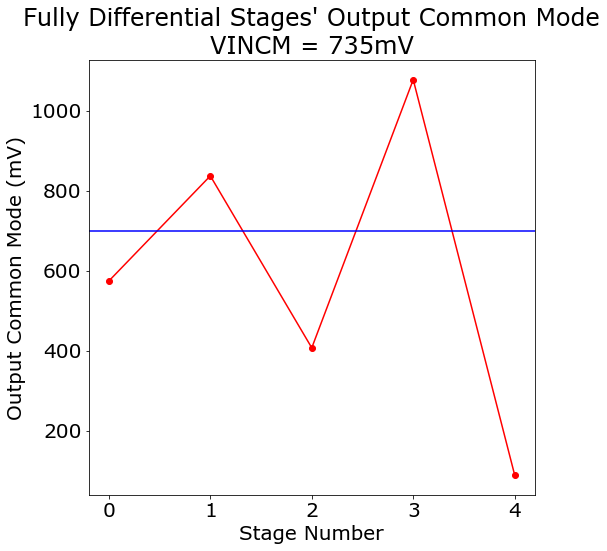

In [49]:
stage_num = np.arange(0,5,1)
vincm_vec = np.array([574.5, 837.4, 407.3, 1078, 89.13])

figsize = (8, 8)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(stage_num, vincm_vec, 'r-o')
ax.set_xlabel("Stage Number")
ax.set_ylabel("Output Common Mode (mV)")
ax.set_title("Fully Differential Stages' Output Common Mode\nVINCM = 735mV")
ax.set_xticks(stage_num)
ax.axhline(700, color='b')
# ax.grid(True);

<h2>Scan Chain Shenanigans</h2>

In [9]:
order = [110,93,68,51,176,153,134,123,69,50,122,81,166,163,175,154,112,91,70,49,79,40,167,162,132,125,113,90]
print(order[::-1])

[90, 113, 125, 132, 162, 167, 40, 79, 49, 70, 91, 112, 154, 175, 163, 166, 81, 122, 50, 69, 123, 134, 153, 176, 51, 68, 93, 110]


In [2]:
.83-.38

0.44999999999999996

In [3]:
(.96-.38)/2

0.29

In [15]:
1.45-2*.38

0.69

In [16]:
.69/3

0.22999999999999998

In [88]:
def cadence_ranges(lst):
    result = []
    lst_sort = list(lst)
    lst_sort.sort()
    if len(lst) < 1:
        return result

    val_start = lst_sort[0]
    val_prev = lst_sort[0]
    if len(lst) < 2:
        return f'{val_start}'

    for i, v in enumerate(lst_sort[1::]):
        if v != val_prev + 1:
            if val_start == val_prev:
                result.append(f"{val_start}")
            else:
                result.append(f"{val_start}:{val_prev}")
            val_start = v
        val_prev = v
            
        if i==len(lst_sort)-2:
            if val_start == val_prev:
                result.append(f"{val_start}")
            else:
                result.append(f"{val_start}:{val_prev}")
        
    return result

In [89]:
cadence_ranges([1, 2, 3, 5, 6, 7, 8, 10, 11])

['1:3', '5:8', '10:11']

In [92]:
hv_vals = [x for x in range(195,207)]

bool_noninv = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]
bool_inv = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]

lst_noninv = [i for i,b in enumerate(bool_noninv) if (not b) and (i not in hv_vals)]
lst_inv = [i for i,b in enumerate(bool_inv) if (not b) and (i not in hv_vals)]
lst_hv = [i for i,b in enumerate(bool_noninv) if (not b) and (i in hv_vals)]
print(len(lst_noninv))
print(len(lst_inv))

91
108


In [91]:
ranges_noninv = cadence_ranges(lst_noninv)
ranges_inv = cadence_ranges(lst_inv)
ranges_hv = cadence_ranges(lst_hv)
print('<' + ','.join(ranges_noninv) +  '>')
print('<' + ','.join(ranges_inv) +  '>')

<0:38,45,48,52:56,63:67,71,74,87,94:98,101:102,105:109,136:140,144,147:151,177:182,185:186,189:194>
<39:44,46:51,57:62,68:73,75:86,88:93,99:104,110:135,141:143,145:146,152:176,183:184,187:188>
